In [66]:
import pandas as pd
import numpy as np
from sktime.performance_metrics.forecasting import mean_absolute_error

from data_processing_functions import *
from data_protection_functions import *

from sktime.utils.plotting import plot_series

### Import data - calculate adjustment directions

In [67]:
# import datasets
full_data = pd.read_csv("../../Data/Train/Clean/full_m3_monthly_micro_clean.csv", header=None, skiprows=1)

# convert to a list of series, potentially with different lengths
# drop NA values
full_data = [x.dropna() for _, x in full_data.iterrows()]

# forecast horizon
h = 1

# create train and test set using forecast horizon
Y = [x.iloc[:-h] for x in full_data]

# apply differential privacy protection
Y_protected = apply_data_protection(Y, coding_type="Top", coding_percentage=0.4)

processed, _, _, _, _ = pre_process(ts_data=Y,
                                    target_forecast_period=h,
                                    log=True)

processed_protected, _, _, _, _ = pre_process(ts_data=Y_protected,
                                    target_forecast_period=h,
                                    log=True)

test_data = pd.read_csv("../../Outputs/Forecasts/Test_h1.csv")
original_forecasts = pd.read_csv("../../Outputs/Forecasts/TES_h1_original.csv")
protected_forecasts = pd.read_csv("../../Outputs/Forecasts/TES_h1_Top_0.1.csv")

In [68]:
# collapsed_original = pd.concat([row for i, row in original_forecasts.iterrows()], ignore_index=True)
# collapsed_protected = pd.concat([row for i, row in protected_forecasts.iterrows()], ignore_index=True)
# collapsed_test = pd.concat([row for i, row in test_data.iterrows()], ignore_index=True)

In [69]:
# split into lists
test_data = [test_data[col] for col in test_data]
original_forecasts = [original_forecasts[col] for col in original_forecasts]
protected_forecasts = [protected_forecasts[col] for col in protected_forecasts]

In [70]:
# booleans for adjustment direction
adjusted_up = [protected_forecasts[i] > original_forecasts[i] for i, _ in enumerate(protected_forecasts)]
adjusted_down = [protected_forecasts[i] < original_forecasts[i] for i, _ in enumerate(protected_forecasts)]

***

### Function to Calculate AvgRelMAE

In [71]:
def AvgRelMAE(test_series, original_fcasts, protected_fcasts, t):
    r = [mean_absolute_error(test_series[i], protected_fcasts[i])/mean_absolute_error(test_series[i], original_fcasts[i]) for i, _ in enumerate(test_series)]
    n = [len(j) for i, j in enumerate(protected_fcasts)]
    nlogr = [n[i]*np.log(r[i]) for i, _ in enumerate(r)]
    nlogr.sort()
    trim_val = int(t*len(nlogr))
    nlogr = nlogr[trim_val:]
    nlogr = nlogr[:-trim_val]
    return (1 - np.exp((1/np.sum(n))*np.sum(nlogr))) * 100

### Calculate AvgRelMAE for Positive Adjusted Forecasts

In [72]:
test_up = [test_data[i][j] for i, j in enumerate(adjusted_up) if len(test_data[i][j]) > 0]

In [73]:
orig_up = [original_forecasts[i][j] for i, j in enumerate(adjusted_up) if len(original_forecasts[i][j]) > 0]

In [74]:
# subset original data to those series with positive adjusted forecasts
up_indexes = np.where([j[0] for i, j in enumerate(adjusted_up)])[0]

In [75]:
Y_up = [Y[i] for i in up_indexes]

In [76]:
Y_up_df = pd.DataFrame(Y_up)

In [77]:
Y_up_df.to_csv("../../Data/Adjustment Data/tes_up_original.csv", index=False)

In [78]:
Y_protected_up = [Y_protected[i] for i in up_indexes]

In [79]:
Y_protected_up_df = pd.DataFrame(Y_protected_up)

In [80]:
Y_protected_up_df.to_csv("../../Data/Adjustment Data/tes_up_protected.csv", index=False)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='1'>)

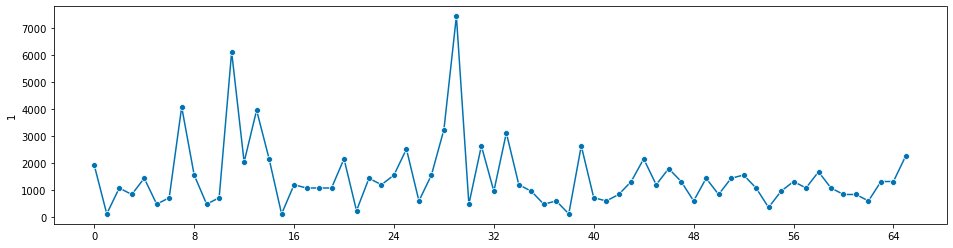

In [81]:
plot_series(Y_up[1])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

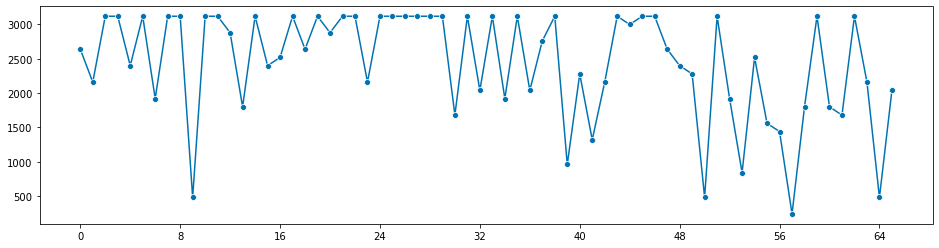

In [82]:
plot_series(Y_protected_up[0])

## Examine The Series with Improved Accuracy Adjusted Up Under Top Coding

In [83]:
protected_up = [protected_forecasts[i][j] for i, j in enumerate(adjusted_up) if len(protected_forecasts[i][j]) > 0]

In [84]:
AvgRelMAE(test_up, orig_up, protected_up, 0.05)

2.1291402446138807

***

### Calculate AvgRelMAE for Negative Adjusted Forecasts

In [85]:
test_down = [test_data[i][j] for i, j in enumerate(adjusted_down) if len(test_data[i][j]) > 0]

In [86]:
orig_down = [original_forecasts[i][j] for i, j in enumerate(adjusted_down) if len(original_forecasts[i][j]) > 0]

In [87]:
# subset original data to those series with positive adjusted forecasts
down_indexes = np.where([j[0] for i, j in enumerate(adjusted_down)])[0]

In [88]:
Y_down = [Y[i] for i in down_indexes]

In [89]:
Y_down_df = pd.DataFrame(Y_down)

In [91]:
Y_down_df.to_csv("../../Data/Adjustment Data/tes_down_original.csv", index=False)

In [92]:
Y_protected_down = [Y_protected[i] for i in down_indexes]

In [93]:
Y_protected_down_df = pd.DataFrame(Y_protected_down)

In [94]:
Y_protected_down_df.to_csv("../../Data/Adjustment Data/tes_down_protected.csv", index=False)

In [95]:
protected_down = [protected_forecasts[i][j] for i, j in enumerate(adjusted_down) if len(protected_forecasts[i][j]) > 0]

In [96]:
AvgRelMAE(test_down, orig_down, protected_down, 0.05)

1.6090978032646697

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='11'>)

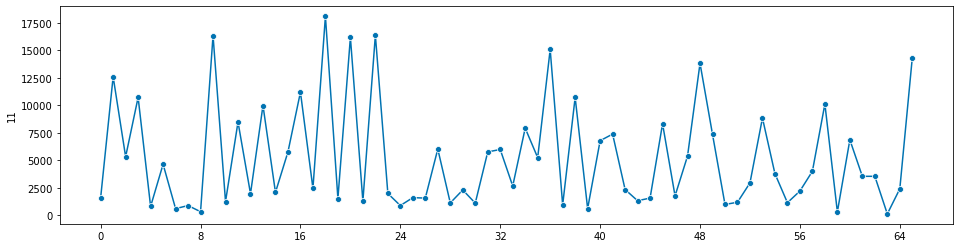

In [97]:
plot_series(Y_down[7])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

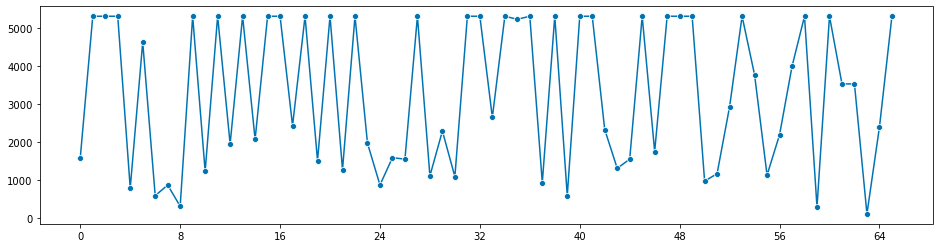

In [98]:
plot_series(Y_protected_down[7])

***

## Series Level MAE Ratio

In [110]:
test_up = pd.concat(test_up, axis=1)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [111]:
test_down = pd.concat(test_down, axis=1)

In [112]:
orig_up = pd.concat(orig_up, axis=1)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [126]:
orig_down = pd.concat(orig_down, axis=1)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [ ]:
orig_down.to_csv("../../Outputs/Data/tes_orig_down.csv")

In [114]:
original_up_mae = mean_absolute_error(test_up, orig_up, multioutput='raw_values')

In [115]:
original_down_mae = mean_absolute_error(test_down, orig_down, multioutput='raw_values')

In [117]:
protected_up = pd.concat(protected_up, axis=1)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [118]:
protected_down = pd.concat(protected_down, axis=1)

In [119]:
protected_up_mae = mean_absolute_error(test_up, protected_up, multioutput='raw_values')

In [120]:
protected_down_mae = mean_absolute_error(test_down, protected_down, multioutput='raw_values')

In [121]:
is_better_up = protected_up_mae/original_up_mae < 1
better_up = np.where(is_better_up)[0]

In [122]:
is_better_down = protected_down_mae/original_down_mae < 1
better_down = np.where(is_better_down)[0]

In [123]:
np.mean(is_better_down)

0.5083333333333333

In [124]:
np.mean(is_better_up)

0.5854700854700855

In [125]:
better_down

array([  0,   2,   4,   5,   7,   9,  10,  11,  13,  15,  18,  19,  23,
        24,  25,  28,  30,  32,  33,  34,  37,  38,  40,  42,  44,  45,
        46,  47,  50,  51,  53,  58,  61,  62,  64,  66,  67,  68,  69,
        70,  71,  72,  75,  76,  77,  78,  79,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95, 101, 102, 103, 106, 107,
       108, 109, 110, 112, 114, 115, 116, 117, 118, 119, 120, 122, 124,
       126, 127, 134, 136, 142, 143, 144, 145, 146, 147, 148, 149, 157,
       158, 159, 160, 166, 168, 171, 175, 176, 184, 186, 189, 195, 201,
       203, 205, 210, 211, 212, 213, 216, 218, 222, 223, 224, 225, 230,
       231, 232, 234, 238, 239], dtype=int64)

In [ ]:
better_Y_up = [Y_up[i] for i in better_up]

In [ ]:
plot_series(better_Y_up[0])

In [ ]:
plot_series(better_Y_up[1])

***

### Calculate MAE ratio for all forecasts - see how many actually improved

***

### Save Series Adjusted Upward vs. Downward

In [ ]:
pd.DataFrame(Y_up)

In [ ]:
Y_up.to_csv("../../Outputs/Tables/ses_series_up.csv", index=False)

In [ ]:
Y_protected_up

***

### Proportion of Forecasts Adjusted in Either Direction

In [ ]:
np.mean(adjusted_up)

In [ ]:
np.mean(adjusted_down)

### Magnitude of Adjustments

In [ ]:
absolute_size_up = [np.abs(orig_up[i] - protected_up[i]) for i, _ in enumerate(orig_up)]

In [ ]:
np.mean(np.concatenate(absolute_size_up))

In [ ]:
np.mean(absolute_size_up)

In [ ]:
absolute_size_down = [np.mean(np.abs(orig_down[i] - protected_down[i])) for i, _ in enumerate(orig_down)]

In [ ]:
np.mean(absolute_size_down)